## Title: What makes trending Youtube videos REALLY trending?

## Motivation & Problem Statement
As someone who spends a considerable amount of time watching youtube videos, both as a source of entertainment and for information, I was interested in finding out how certain videos become extremely popular as compared to others. Since the amount of subscribers alone do not determine the popularity, I was curious to find out exactly what factors play into catapulting youtube videos to the top trending list.
Another motivation for this project comes from the fact several of my friends are youtube content creators who are unable to market their videos as efficiently and are ignorant to the underlying algorithm of Youtube. All the analysis in this notebook aims to find trends in the statistics and how these insights can be leveraged to actionable practices.
I am interested in finding out what  factors make popular or viral youtube videos go viral. I also want to find out if these factors vary from country to country and how so. While the former part of my question involves a large amount of quantitative analysis. I aim to incorporate some qualitative study to understand exactly why or how these factors differ. It would be interesting to find out if there is a difference category wise, region wise or if it's simply based on the most trending topics on youtube overall. The goal is to extract as much information as possible about the users and content creator associations on Youtube.In order to determine the factors, I will implement Linear regression models due to ease of interpretability of the outcomes.
I believe that insights from this research study will hold value for two groups mainly, the viewers and the content creators. Creators can have a better understanding of what governs the popularity of their video and how they can change/incorporate their current content publishing practices. Viewers can (hopefully) learn to differentiate between click-bait thumbnail videos and gain clarity on how to identify the trending videos in each category.


## Data 
Data : Collected from Youtube API  
Data source: https://www.kaggle.com/datasnaek/youtube-new (https://github.com/DataSnaek/Trending-YouTube-Scraper)**    
This dataset contains all the information related to the top trending/viral Youtube videos region wise. It contains information of about 200 trending videos per day for several months in different regions(USA, Great Britain, Germany, Canada,France,Russia, Mexico, South Korea, Japan and India) such as:   
video_id  
trending_date  
title  
channel_title  
category_id  
publish_time  
tags  
views  
likes  
dislikes  
comment_count  
thumbnail_link  
comments_disabled  
ratings_disabled  
video_error_or_removed  
description  
I would be using a subset of the data as it is a very large dataset(514 MB)

## Dataset License
Licence: BSD 2-Clause "Simplified" License ** 

## Project License
This project is licensed under MIT License

## Possible bias/dependencies in Data
As I aim to determine what factors make a Youtube video popular overall and in each country, this analysis may inherently be dependent on the user defined labels of the videos. For instance, some music videos are tagged under 'Entertainment', while some are tagged under 'People & Blogs'. This cannot be corrected and hence the user inflicted bias can cause some randomness in the analysis. Additionally the privacy laws and laws governing mass media and communication, the censor board laws and so on, of each region also varies, which can lead to skews in the trends found in categories with respect to each country. So there is a possibility that the results cannot be completely generalized. I also suspect that access to internet and technology among the population would vary between each region and this would also be a governing factor in which videos make it to the top trending list. I will aim to include some qualitative research as well to the outcomes I find in my analysis.

## Research questions and/or hypotheses   
1) What are the factors that determine the popularity of a youtube video?    
3) How do these vary in each category?  
2) How do these factors vary from country to country?    

## Background and/or Related Work  
It is known that youtube videos released by channels/creators with high number of subscribers receive more views,likes,comments and therefore become popular/trending. There are probably many analyses of the like that try to determine which factors control the popularity. However, the aim of this project is to see how these factors differ from country to country and why do they differ? Can these differences be reasoned by statistics pertaining to the demography in each country or is there more to it? Are socio-economic or political atmosphere of the country have a role as well? The aim is to also observe how the popularity factors vary from category to category. Thsi analysis will also include some qualtitative insights presented along with the statistical inferences.
There are several kernels that have used this dataset for analyses, although I have described how and why my analyses will be different from the existing ones, the exploratory data analyses might be similar due to the nature of data and prevailing assumptions.

## Methodology  
* Pre-processing  
A subset of the data will be used for the analyses. The size of this subset will be decided after performing some exploratory data analysis to understand how sparse/not sparse is the data. To determine how these factors vary over different categories, a set of 5-10 categories will be chosen for comparison.
* Statitical Analysis Method    
Linear Regression models will be used to train and determine the predictors. This method is appropriate as all the data points are independent and the sample size is large enough to meet the normality assumption. This also provides ease in interpreting the results and verifying the correlations statitiscally.

## Results are summarized in the end


## Import necessary Libraries

In [16]:
import json
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import time
from datetime import datetime
import seaborn as sns

### Analysing the statistical data of 7 chosen countries: Canada (CA), Germany (DE), Great Britain (GB), India (IN), South Korea (KR), Russia (RU), United States (US). All data from Dec 1st 2017 to May 31st 2108. Ingest the data from the respective csv files located in Data folder of the repo.

In [3]:
#Read data from csv
CA = pd.read_csv('./Data/CAvideos.csv') #canada
DE = pd.read_csv('./Data/DEvideos.csv') #germany
GB = pd.read_csv('./Data/GBvideos.csv') #great britain
IN = pd.read_csv('./Data/INvideos.csv') #india
KR = pd.read_csv('./Data/KRvideos.csv',encoding='latin-1') #south korea
RU = pd.read_csv('./Data/RUvideos.csv',encoding='latin-1') #russia
US = pd.read_csv('./Data/USvideos.csv') #usa


#Drop null values
US = US.dropna()
CA = CA.dropna()
DE = DE.dropna()
IN = IN.dropna()
GB = GB.dropna()
KR = KR.dropna()
RU = RU.dropna()

cat_jsons = [('CA',CA),('DE',DE),('GB',GB),('US',US),('IN',IN),('RU',RU),('KR',KR)]

#List of the dataframes
dfs = [x[1] for x in cat_jsons]



### Create category column for each dataframe. Create category dictionary for each country from corresponding JSON file using category ID and title. Further pre-processing steps to create 'country' column, convert date values to datetime type, converting object type to int type, create additional columns to denote 'publish_time','publish_hour', 'days_to_trend'.

In [4]:


for cat in cat_jsons:
    file = './youtube-new/'+str(cat[0])+'_category_id.json'
    with open(file) as f:
        data = json.load(f)
    cat_dict = {}
    #create category dictionary
    for i in range(len(data['items'])):
        cat_dict[data['items'][i]['id']] = data['items'][i]['snippet']['title']
    
    #create country column for each dataframe
    cat[1]['country'] = cat[0]
    
    #create category column for each dataframe
    cat[1]['category'] = [ cat_dict.get(str(x),None)  for x in cat[1].category_id]
    
    #convert category_id to int type
    cat[1][['category_id']] = cat[1][['category_id']].astype(int)  
    
    #convert category tags to strings seperated by ','
    cat[1].tags = cat[1].tags.apply( lambda x : x.replace('|',',') if x else "")
    
    #convert date to unixtimestamp type
    cat[1].trending_date = cat[1].trending_date.apply( lambda x : x.replace('.','-') if x else "")
    cat[1].trending_date = cat[1].trending_date.apply( lambda x : '20'+x)
    
    cat[1].trending_date = cat[1].trending_date.apply( lambda x : time.mktime(datetime.strptime(x, "%Y-%d-%m").timetuple()))

    cat[1].trending_date = cat[1].trending_date.apply(lambda x : datetime.fromtimestamp(x).strftime('%Y-%m-%dT%H:%M:%S.%fZ'))
    #convert publish time and trending_date to datetime
    cat[1]['trending_date'] = pd.to_datetime(cat[1]['trending_date'], format='%Y-%m-%dT%H:%M:%S.%fZ')
    cat[1]['publish_time'] = pd.to_datetime(cat[1]['publish_time'], format='%Y-%m-%dT%H:%M:%S.%fZ')
    
    #days to trend
    cat[1]['days_to_trend'] = cat[1]['trending_date'].dt.date-cat[1]['publish_time'].dt.date

    #publish hour
    cat[1]['publish_hour'] = cat[1].publish_time.dt.hour
    
    

In [14]:
## Concat all dataframes to perfrom overall analysis
combined = pd.concat(dfs, axis =0)
combined = combined.dropna(how='any',axis=0)
combined = combined.drop_duplicates(subset = ['publish_time'], keep = 'first')

## Apply transformations similar to above pre-processing step
combined['days_to_trend'] = combined['trending_date'].dt.date-combined['publish_time'].dt.date
combined['publish_hour'] = combined.publish_time.dt.hour
num_views = combined['views'].sort_values()

## Create like/dislike ratio column
combined['like_ratio']= combined.likes/combined.dislikes


## Let's take a look at the data!

In [6]:
combined.head(2)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,country,category,days_to_trend,publish_hour
0,n1WpP7iowLc,2017-11-14,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,10,2017-11-10 17:00:03,"Eminem,""Walk"",""On"",""Water"",""Aftermath/Shady/In...",17158579,787425,43420,125882,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg,False,False,False,Eminem's new track Walk on Water ft. Beyoncé i...,CA,Music,4 days,17
1,0dBIkQ4Mz1M,2017-11-14,PLUSH - Bad Unboxing Fan Mail,iDubbbzTV,23,2017-11-13 17:00:00,"plush,""bad unboxing"",""unboxing"",""fan mail"",""id...",1014651,127794,1688,13030,https://i.ytimg.com/vi/0dBIkQ4Mz1M/default.jpg,False,False,False,STill got a lot of packages. Probably will las...,CA,Comedy,1 days,17


## Create wordclouds of tags

In [7]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)
stopwords.add('dtype')
stopwords.add('tags')
stopwords.add('object')


def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=1000000,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

    



## Let's take a look at some of the commonly used hashtags in the description of various categories

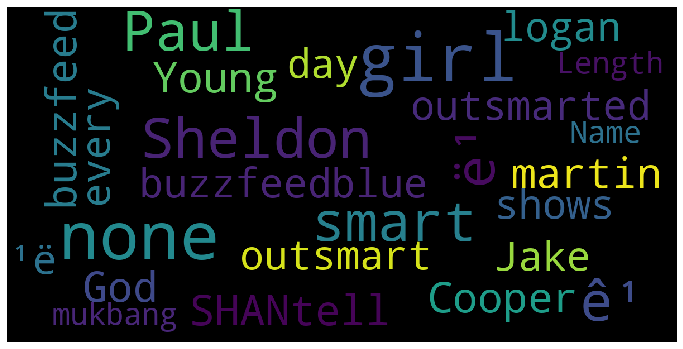

In [8]:
words = combined.loc[combined['category'] == 'People & Blogs']
show_wordcloud(words['tags'])

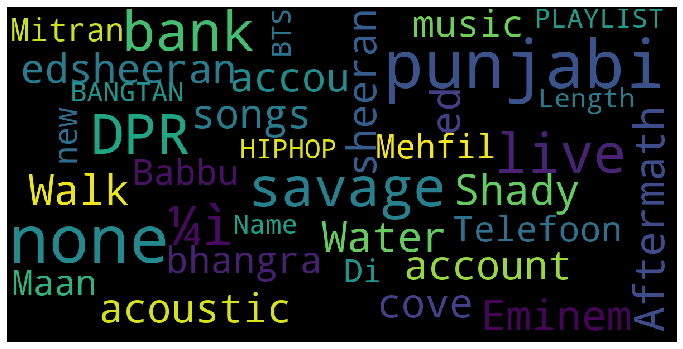

In [9]:
words = combined.loc[combined['category'] == 'Music']
show_wordcloud(words['tags'])

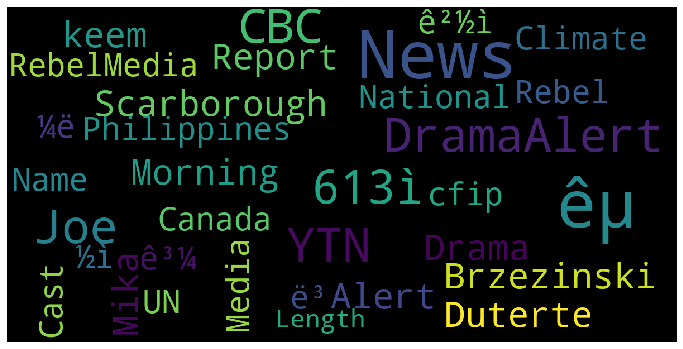

In [11]:
words = combined.loc[combined['category'] == 'News & Politics']
show_wordcloud(words['tags'])

## Let's take a look at what was the most viewed trending video of all time (in the given duration of the dataset)

In [896]:
most_trend = combined[combined.views == num_views.max()]
most_trend

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,country,category,days_to_trend,publish_hour
35515,7C2z4GqqS5E,2018-05-19,BTS (방탄소년단) 'FAKE LOVE' Official MV,ibighit,10,2018-05-18 09:00:02,"BIGHIT,""빅히트"",""방탄소년단"",""BTS"",""BANGTAN"",""방탄""",39349927,3880074,72707,692311,https://i.ytimg.com/vi/7C2z4GqqS5E/default.jpg,False,False,False,BTS (방탄소년단) 'FAKE LOVE' Official MVDirector : ...,CA,Music,1 days,9


## Let's do some EDA
### First let's take a quick look at the data

In [897]:
US.head(2)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,country,category,days_to_trend,publish_hour
0,2kyS6SvSYSE,2017-11-14,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13 17:13:01,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,US,People & Blogs,1 days,17
1,1ZAPwfrtAFY,2017-11-14,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13 07:30:00,"last week tonight trump presidency,""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John...",US,Entertainment,1 days,7


## How many trending videos per country?

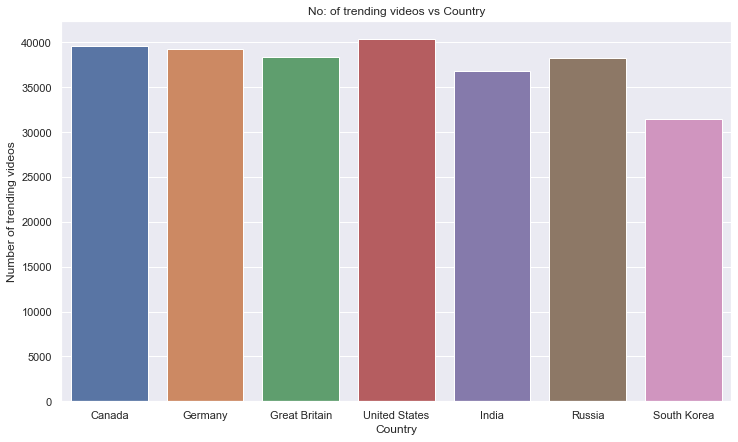

In [898]:
dfs = [len(x[1]) for x in cat_jsons]


plt.figure(figsize=(12,7))
plt.title('No: of trending videos vs Country')
plt.xlabel('Country')
plt.ylabel('Number of trending videos')
sns.barplot(['Canada','Germany','Great Britain','United States','India','Russia','South Korea'],dfs)

## There are roughly equal number of videos from each country. South Korea has the least number of videos

## Research Questions
### Lets try to determine what factors affect the popularity of a youtube video. Considering the number of likes to be proportional to popularity of a video, model a Linear regression with  'views','dislikes','comment_count' ,'publish_hour' as predictors.

In [36]:

X = np.asarray(combined[['views','dislikes','comment_count','publish_hour']])
Y = np.asarray(combined[['likes']])

model = sm.OLS(Y, X)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.712
Model:                            OLS   Adj. R-squared (uncentered):              0.712
Method:                 Least Squares   F-statistic:                          6.316e+04
Date:                Tue, 10 Dec 2019   Prob (F-statistic):                        0.00
Time:                        03:55:11   Log-Likelihood:                     -1.1597e+06
No. Observations:              102374   AIC:                                  2.319e+06
Df Residuals:                  102370   BIC:                                  2.319e+06
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## It can be observed that the number of comments on a video and the hour at which it was published is the most determining factor and is directly proportional to the likes. As expected, the number of dislikes negatively impacts the popularity. Surprisingly, the number of views are not as significant as the number of comments.

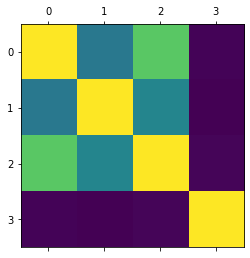

In [37]:
plt.matshow(combined[['likes','dislikes','comment_count','publish_hour']].corr())

##  Data viz
1) look at publish time and likes/views


2) compare top trending categories with less trending categories 
differences in likes

3) country wise top trending categories 

5) top trending videos with comments_disabled

6) country with most comments_disabled videos


## Let's take a look at the number of videos in each category

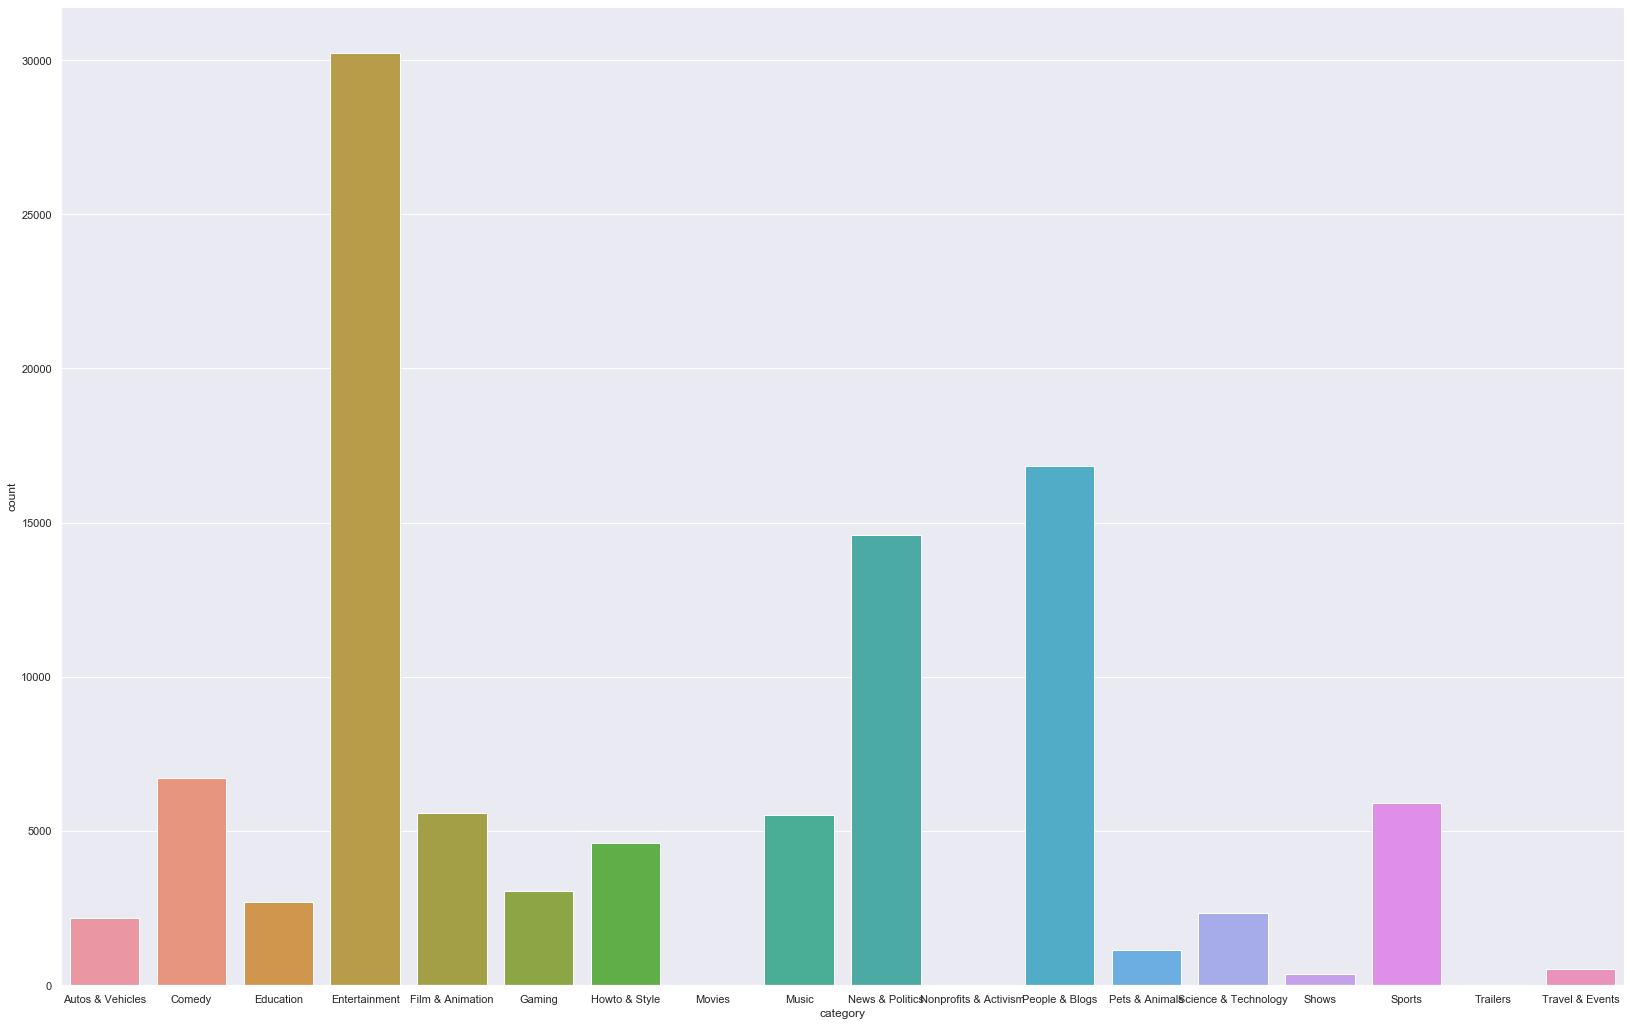

In [936]:
plt.figure(figsize= (28,18))
sns.barplot(cat_count['category'],cat_count['count'] , ci=None)

## As can be seen, Entertainment has the most number of videos overall

## Let's take a look at which category has the most number of likes 

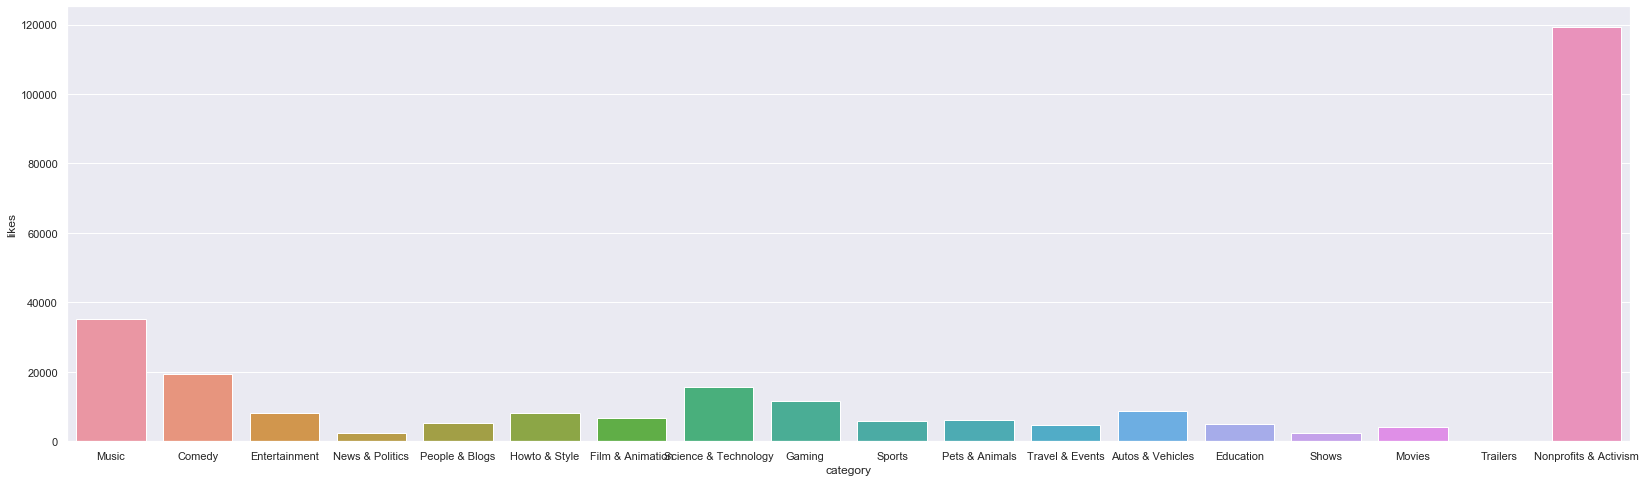

In [925]:
plt.figure(figsize= (28,8))
sns.barplot(combined.category, combined.likes, ci=None)

## Let's take a closer look at 'Nonprofits & Activism' category since it was observed that very few number of videos are present in the category from the previous graph, it is surprising to see that it has the most number of likes

In [935]:
cat_count = combined.groupby('category').size().reset_index(name='count')
test = combined[combined.category == 'Nonprofits & Activism']
test

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,...,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,country,category,days_to_trend,publish_hour,like_ratio
3313,aLSG3178eD4,2017-11-30,Tell Hollywood to stand with immigrants,Define American,29,2017-11-28 13:00:35,"DACA,""black panther""",1456,0,0,...,https://i.ytimg.com/vi/aLSG3178eD4/default.jpg,True,True,False,"Undocumented in Hollywood? Yes, and we are #He...",US,Nonprofits & Activism,2 days,13,NaN
4934,0jmDHoPUGKI,2017-12-08,NSC | Face to Face with the Prescription Opioi...,National Safety Council,29,2017-12-05 13:50:17,"National Safety Council,""Opioid misuse"",""addic...",1967,19,0,...,https://i.ytimg.com/vi/0jmDHoPUGKI/default.jpg,False,False,False,"Each year 22,000 people die from prescription ...",US,Nonprofits & Activism,3 days,13,inf
6463,6kLYXbNZWRs,2017-12-16,Meet Teen Vogue's 2017 21 Under 21 | Teen Vogue,Teen Vogue,29,2017-12-15 17:00:19,"inspiring,""teen vogue"",""21 under 21"",""nadya"",""...",7052,686,13,...,https://i.ytimg.com/vi/6kLYXbNZWRs/default.jpg,False,False,False,"Meet Teen Vogue’s 21 Under 21 class of 2017, f...",US,Nonprofits & Activism,1 days,17,52.769231
7547,xYShiXMGULE,2017-12-21,Living under a bridge doesn't stop this homele...,Invisible People,29,2017-12-17 06:10:08,"mark horvath,""homeless"",""homelessness"",""invisi...",33685,1450,51,...,https://i.ytimg.com/vi/xYShiXMGULE/default.jpg,False,False,False,A few months back I logged onto Facebook and w...,US,Nonprofits & Activism,4 days,6,28.431373
10473,Pc1Obe1BWhc,2018-01-05,Nina Dobrev wants to Save Sharks (30s),Oceana,29,2018-01-03 16:01:48,"Sharks,""Nina Dobrev"",""Shark finning"",""PSA""",4178,16,1,...,https://i.ytimg.com/vi/Pc1Obe1BWhc/default.jpg,False,False,False,"While shark finning is illegal in U.S. waters,...",US,Nonprofits & Activism,2 days,16,16.000000
11541,ESRAQtXVQL0,2018-01-12,Homeless little boy gets a bed for Christmas,Humble Design,29,2018-01-09 02:00:25,"charity,""humble design"",""detroit"",""design"",""ho...",23634,131,13,...,https://i.ytimg.com/vi/ESRAQtXVQL0/default.jpg,False,False,False,Daeyers is eight years old and has been homele...,US,Nonprofits & Activism,3 days,2,10.076923
11925,mt22NvsTRG0,2018-01-14,The Obama Presidential Center: Where We Are Now,Obama Foundation,29,2018-01-12 19:17:22,[none],42194,1384,66,...,https://i.ytimg.com/vi/mt22NvsTRG0/default.jpg,False,False,False,"One year ago, President and Mrs. Obama laid ou...",US,Nonprofits & Activism,2 days,19,20.969697
14000,oWjxSkJpxFU,2018-01-25,Suicide: Be Here Tomorrow.,Logan Paul Vlogs,29,2018-01-24 18:30:01,"logan paul vlog,""logan paul"",""logan"",""paul"",""l...",8041970,1167488,147643,...,https://i.ytimg.com/vi/oWjxSkJpxFU/default.jpg,False,False,False,National Suicide Prevention Lifeline\nCall 1-8...,US,Nonprofits & Activism,1 days,18,7.907507
16706,eIns8Y0xegE,2018-02-07,"Unrigged Live! with Jennifer Lawrence, Tig Not...",Represent.Us,29,2018-02-04 06:12:37,"Unrig,""Unrig the System"",""Unrig the System Sum...",11023,110,33,...,https://i.ytimg.com/vi/eIns8Y0xegE/default.jpg,False,False,False,We're live at Unrig the System Summit in New O...,US,Nonprofits & Activism,3 days,6,3.333333
18475,obRG-2jurz0,2018-02-16,Does saving more lives lead to overpopulation?,Bill Gates,29,2018-02-13 09:50:47,"Bill,""Gates""",107702,5472,192,...,https://i.ytimg.com/vi/obRG-2jurz0/default.jpg,False,False,False,Bill Gates explains his answer to the tough qu...,US,Nonprofits & Activism,3 days,9,28.500000


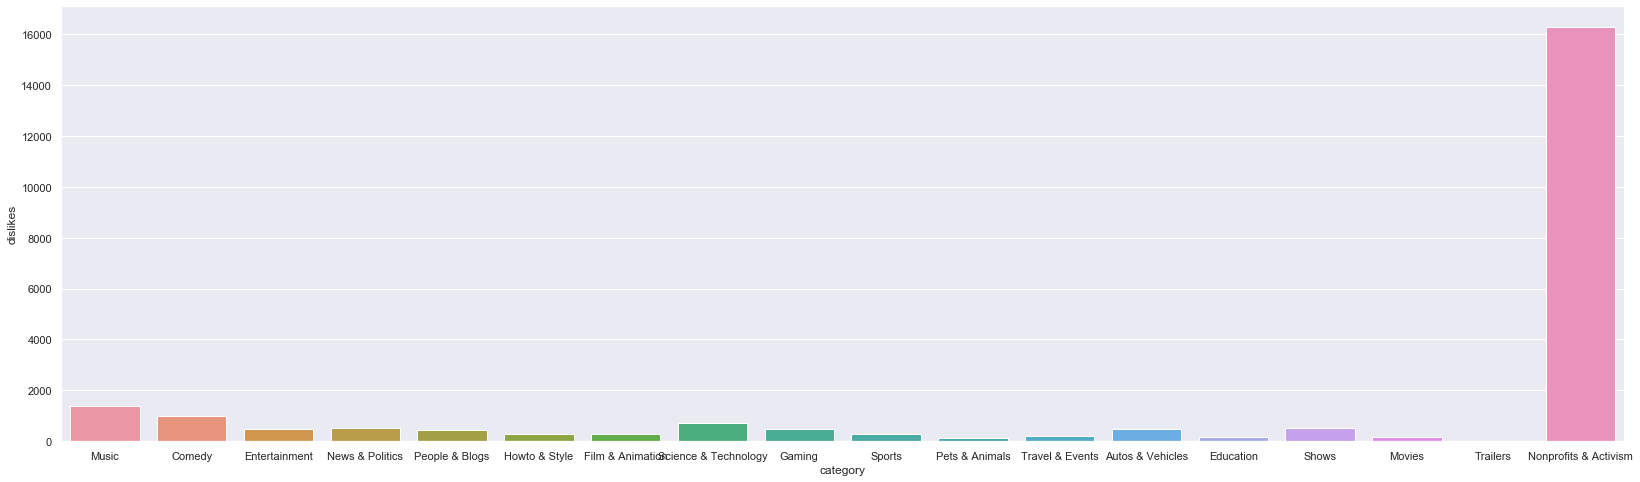

In [926]:
plt.figure(figsize= (28,8))
sns.barplot(combined.category, combined.dislikes, ci = None)

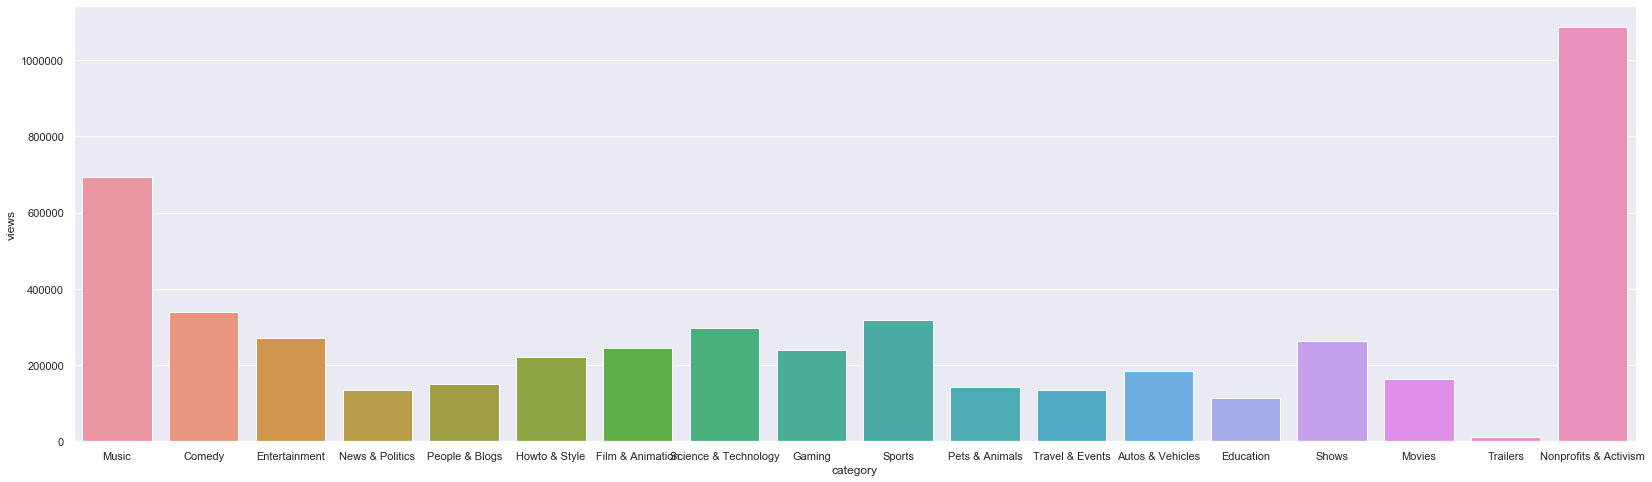

In [927]:
plt.figure(figsize= (28,8))
sns.barplot(combined.category, combined.views, ci=None)

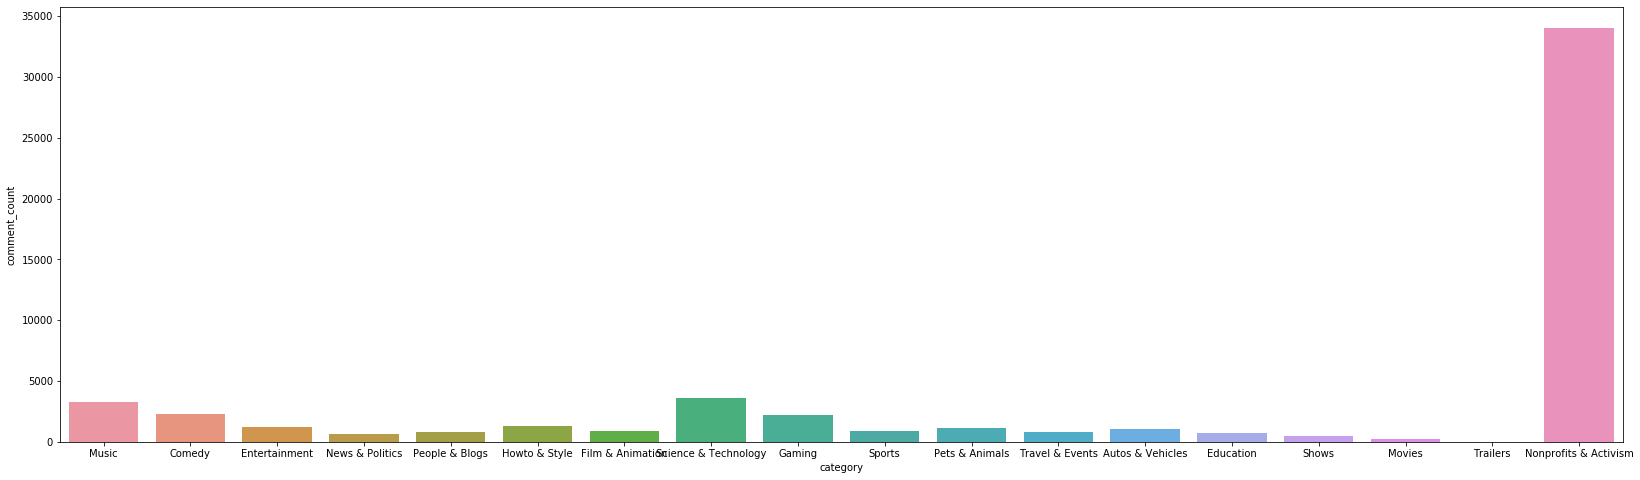

In [17]:
plt.figure(figsize= (28,8))
sns.barplot(combined.category, combined.comment_count, ci=None)

### Upon further analysis of views, comment_count and dislikes, it is evident that the category with the most number of videos does not have the most number of likes. This is interesting because, out of the 13 videos in Nonprofits & Activism, few controversial videos or videos released by controversial youtubers has attracted a lot of traffic. Infact these videos are not exactly Nonprofit or Activisim. This finding correlates with the previous result that the video with more comments will have more likes. It should also be noted that the 'Entertainment' category has very less comments overall. This can also be useful to understand user behaviour, i.e, users tend to react or comment to videos that are controversial or are considered 'offensive' by the user. On the other hand, videos that cater to the likes and taste of the user do not receive as much feedback/reaction as the former!

In [30]:
## Using a duplicate copy of the combined data
combined_sample = combined
len(combined_sample)

102374

## What are the top trending categories in each country?

In [27]:
categories1 = ['Entertainment','Music','People & Blogs','Comedy','Travel & Events']
categories2 = ['News & Politics','Science & Technology','Education','Nonprofits & Activism']
categories3 = ['Sports','Gaming']






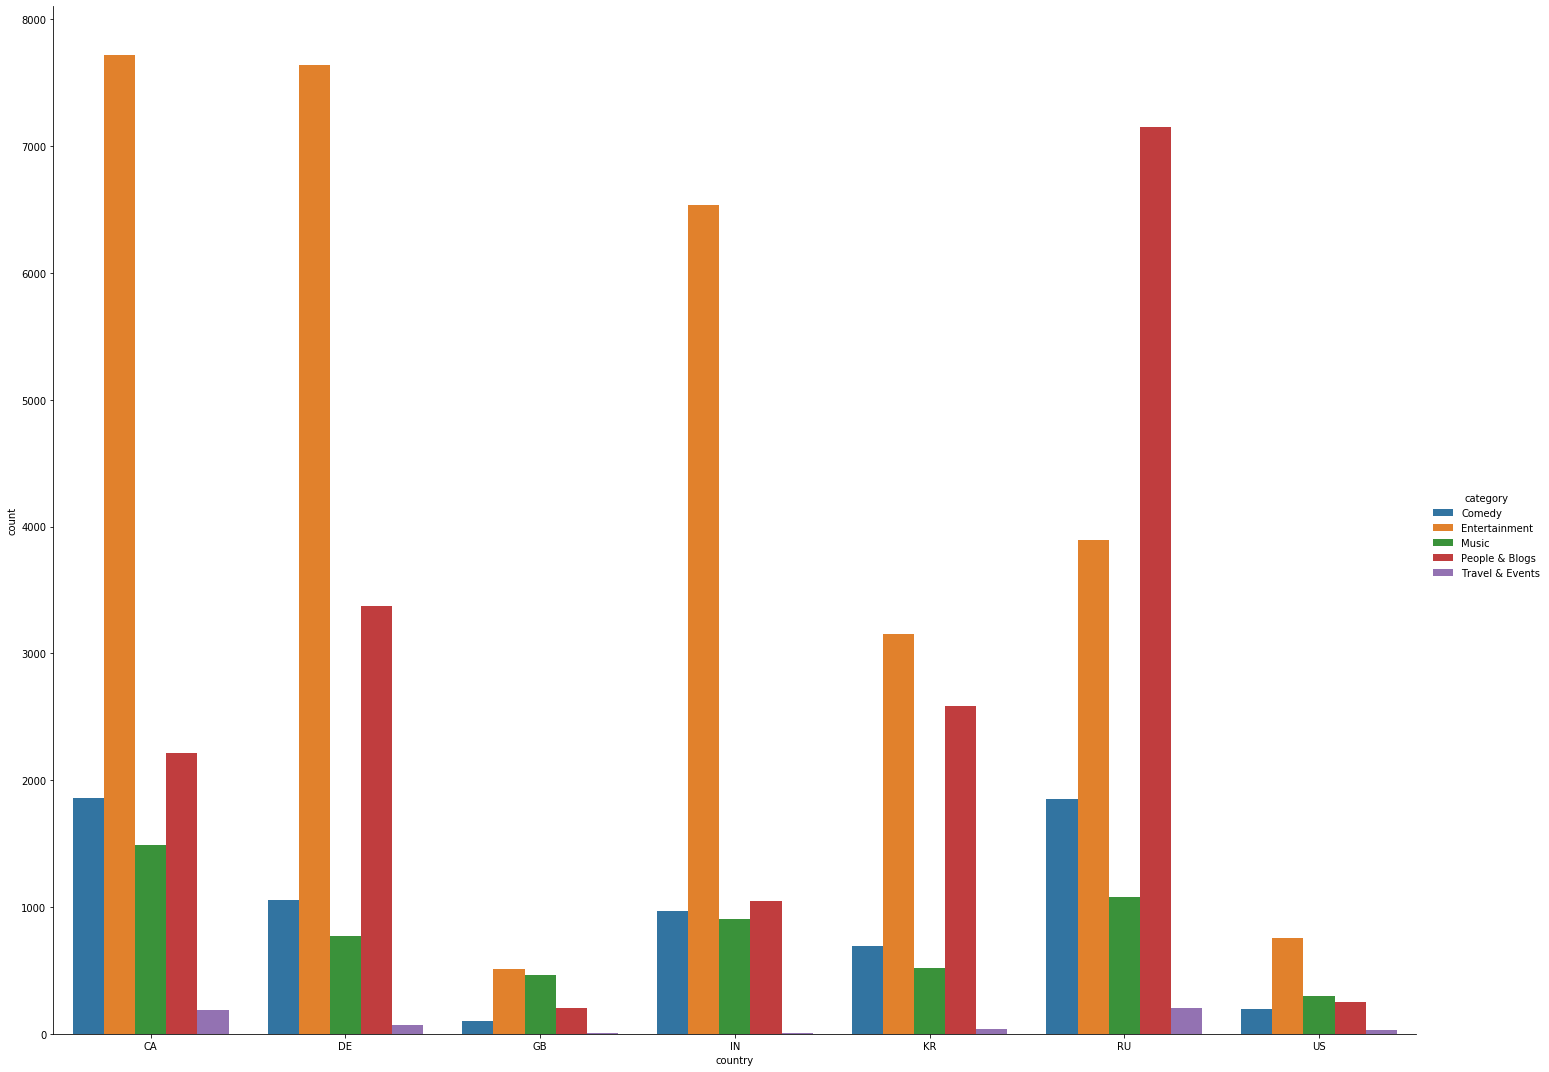

In [22]:
combined_sample = combined
combined_sample = combined_sample[combined_sample.category.isin(categories1)]
df1 = pd.DataFrame(combined_sample.groupby(['country','category']).size().reset_index(name='count'))

sns.catplot(x='country', y='count', hue='category', data=df1, kind='bar', height=15, aspect=20/15)

## There is clear difference in the user preferences of Russian users and other country users. It is also evident that Great britain users give as much importance to Music videos as to Entertainment. Considering the fact that some of the most popular bands of all time are from Great Britain, this explains the equal number of trending music videos in that country.

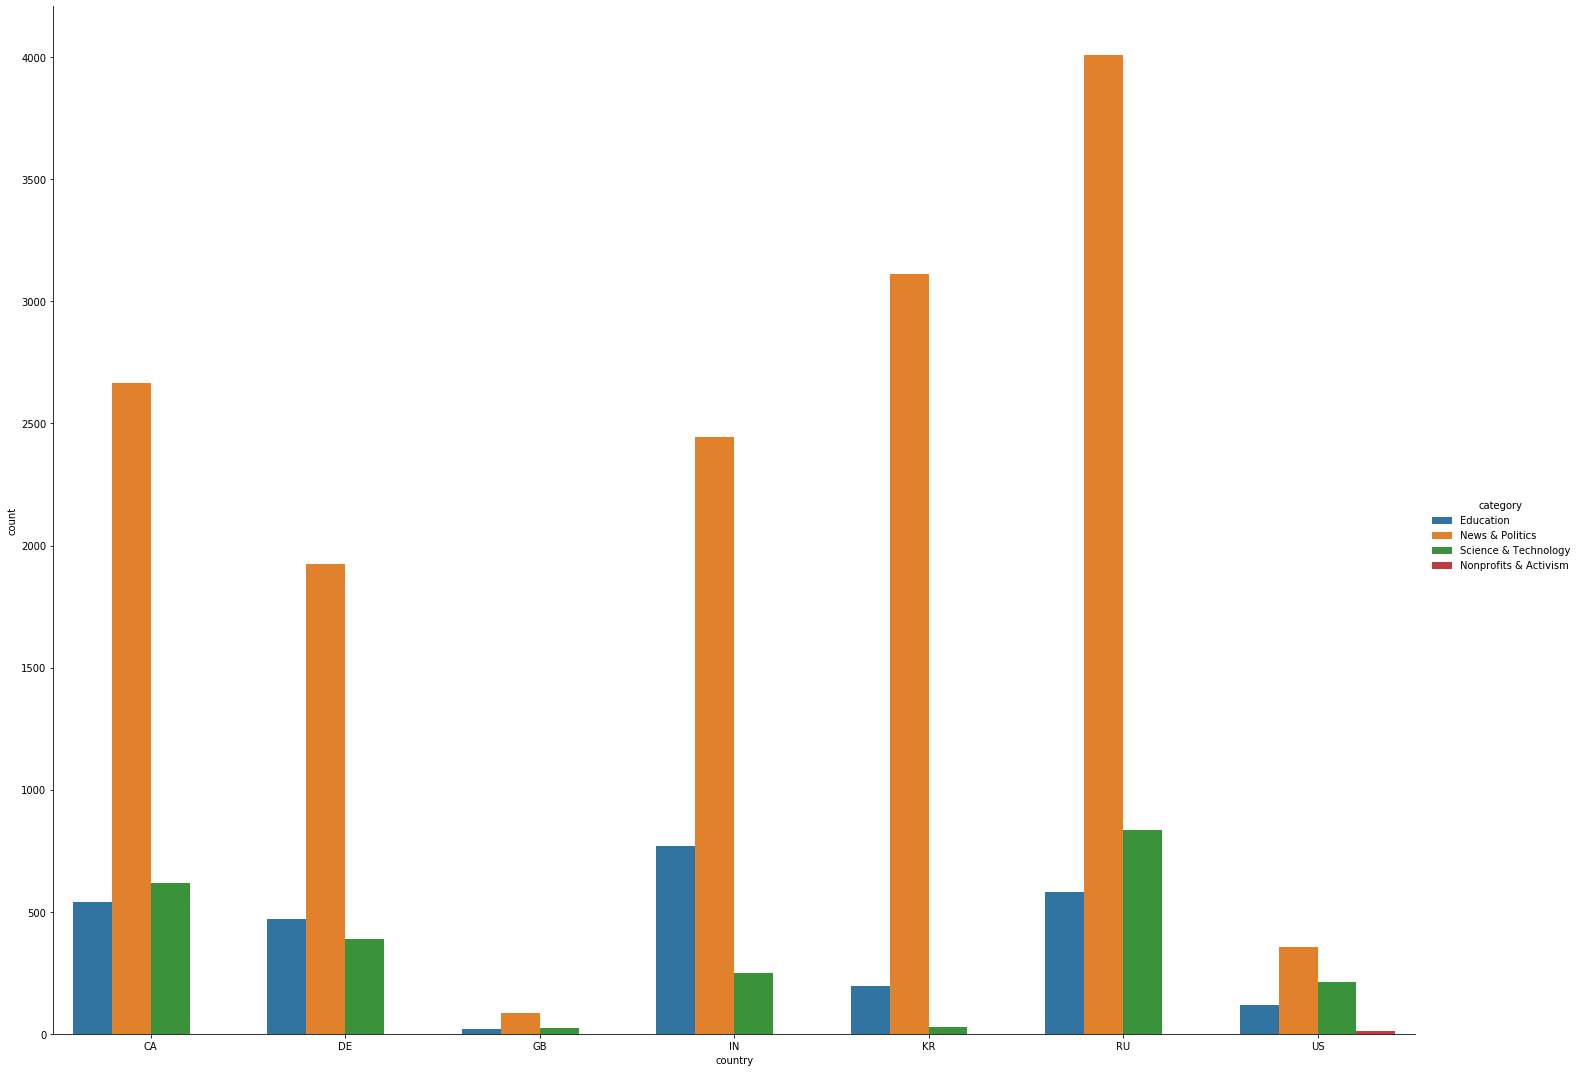

In [25]:
combined_sample = combined
combined_sample = combined_sample[combined_sample.category.isin(categories2)]
df1 = pd.DataFrame(combined_sample.groupby(['country','category']).size().reset_index(name='count'))

sns.catplot(x='country', y='count', hue='category', data=df1, kind='bar', height=15, aspect=20/15)

## News & Politics videos are way more popular than other categories. Russia has the most number of videos, this agrees with the fact that Russia has the most number of TV news channels among all countries.This gap is less in US which has comparable number of videos in Science and technology as well.

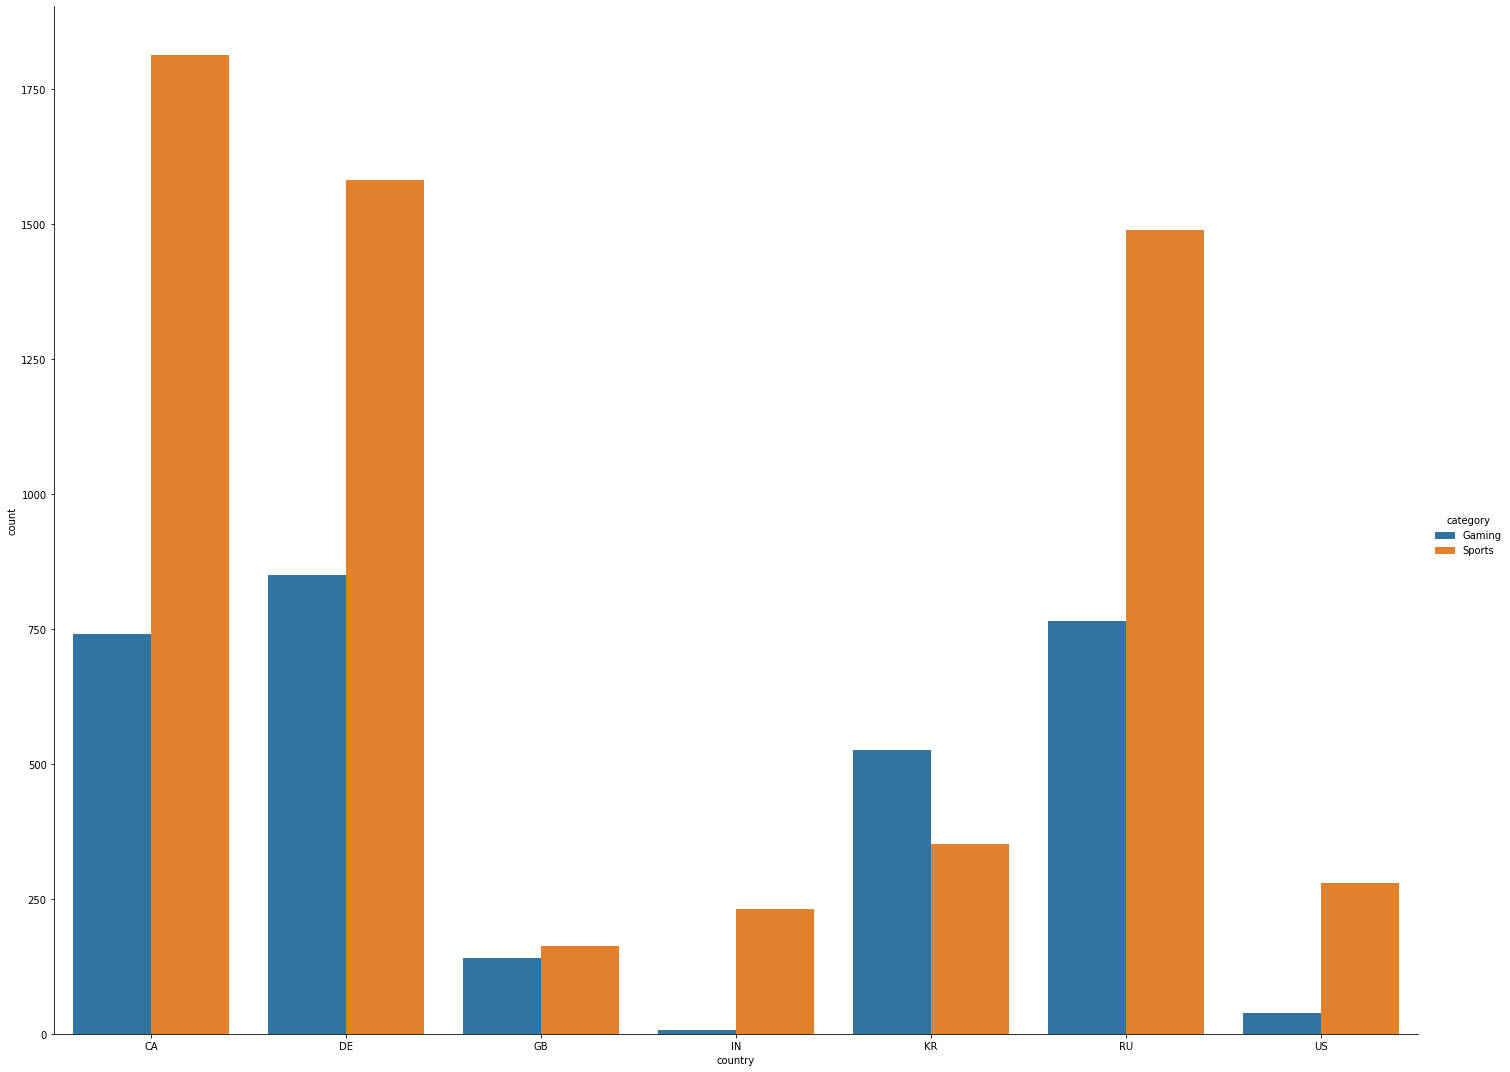

In [28]:
combined_sample = combined
combined_sample = combined_sample[combined_sample.category.isin(categories3)]
df1 = pd.DataFrame(combined_sample.groupby(['country','category']).size().reset_index(name='count'))

sns.catplot(x='country', y='count', hue='category', data=df1, kind='bar', height=15, aspect=20/15)

### In 2018 winter olympics -> Germany had the second highest number of medals followed by canada, thus it explains the surge in the number of videos in the category of Sports.  


## Explore the relationship between publish hour and days to trend for categories

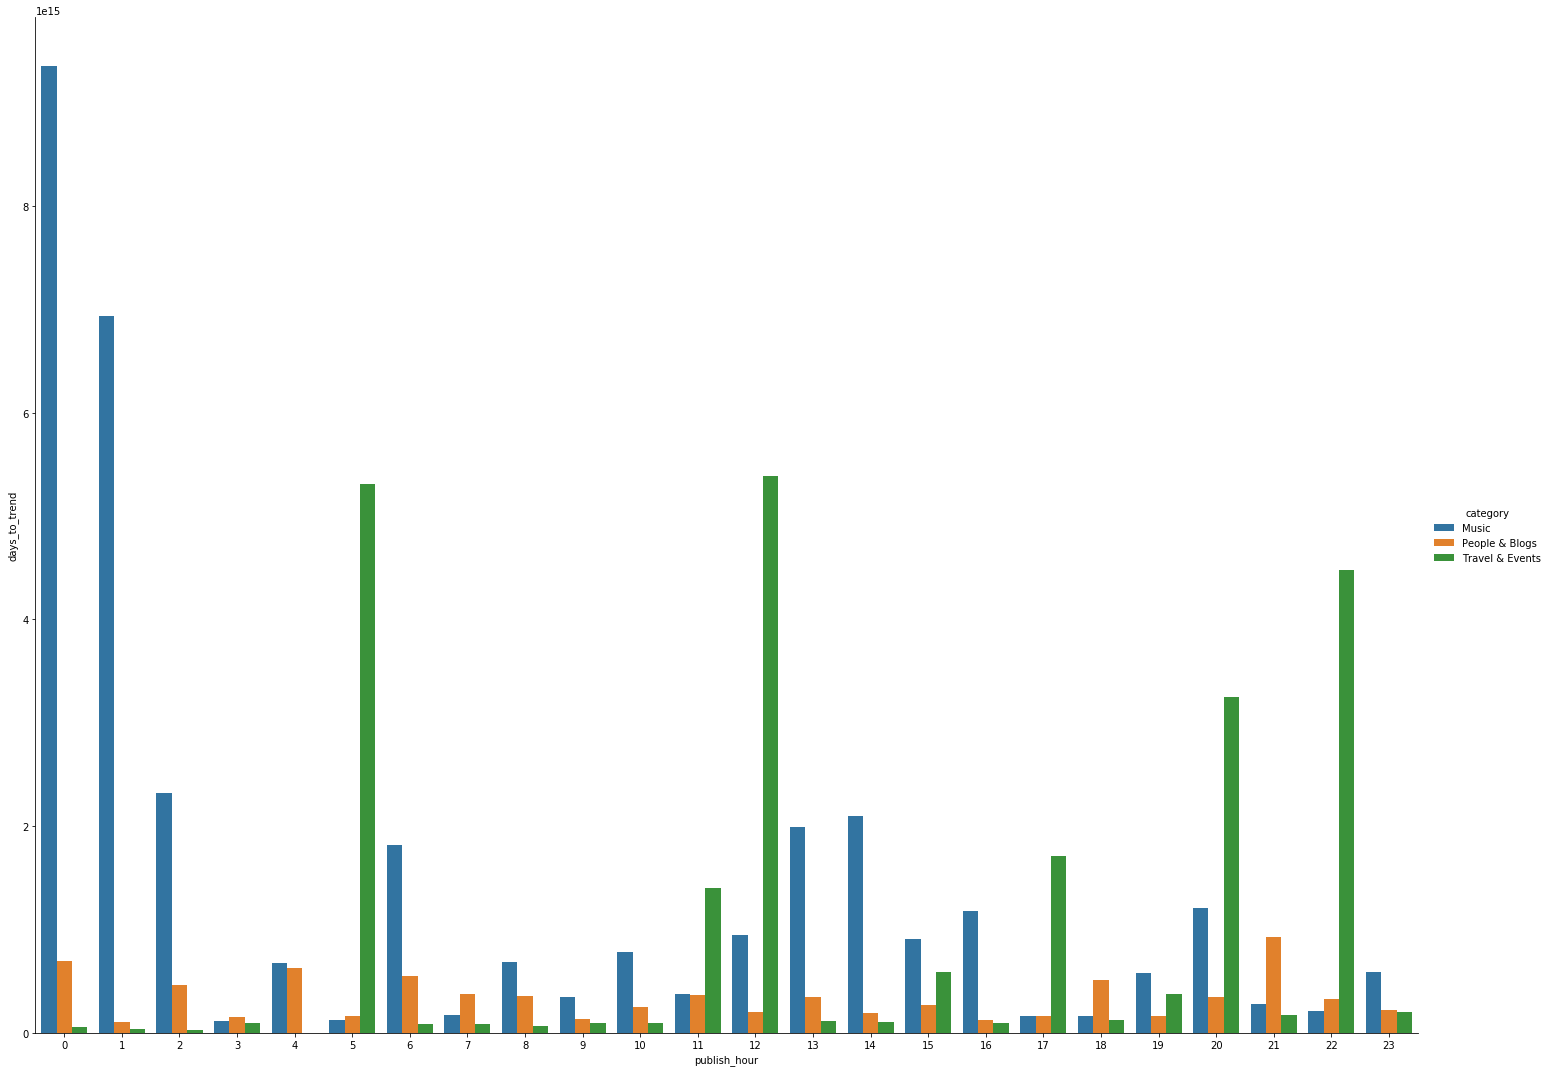

In [33]:
df2 = combined[combined.category.isin(categories1)]
sns.catplot(x='publish_hour', y='days_to_trend', hue='category', data=df2[['category','publish_hour','days_to_trend']], kind='bar', height=15, aspect=20/15, ci=None)

### Music videos take longer to trend on an avg regardless of publish hour, Travel and Events videos are heavily dependent on publish hour

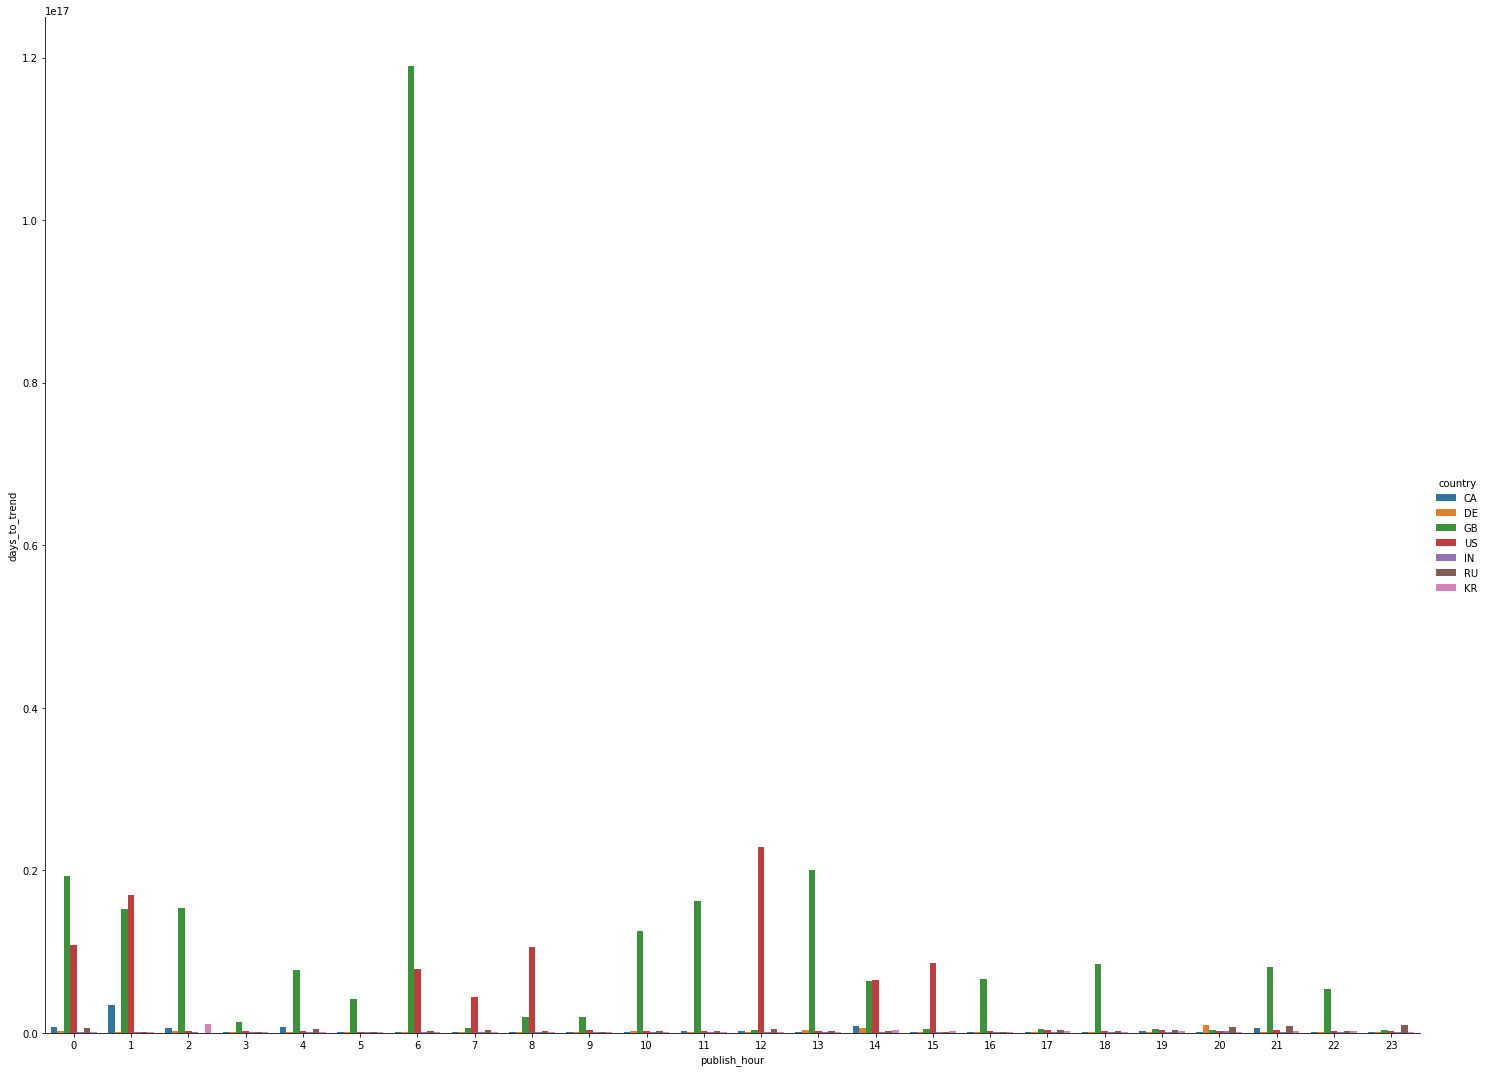

In [35]:
sns.catplot(x='publish_hour', y='days_to_trend', hue='country', data=df2[['country','publish_hour','days_to_trend']], kind='bar', height=15, aspect=20/15, ci=None)



## Videos in US and Great Britain have distinct patterns in the number of days it takes for a video to trend based on the time it was published

## Relationship between publish hour and views

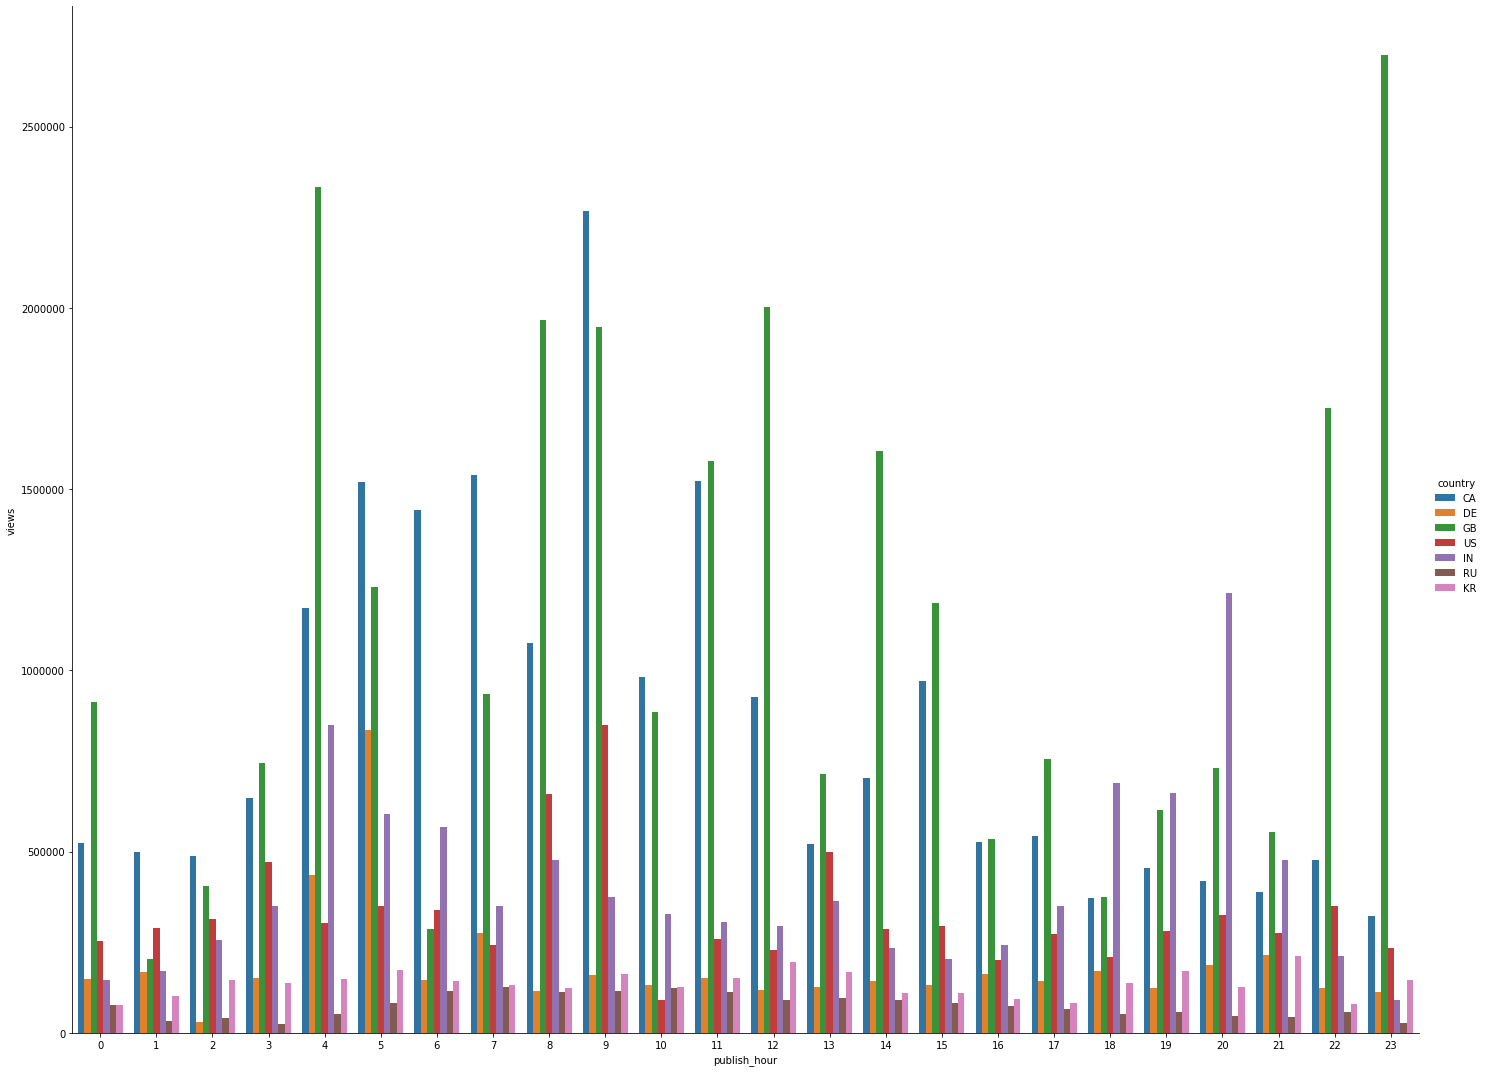

In [39]:
sns.catplot(x='publish_hour', y='views', hue='country', data=df2[['country','publish_hour','views']], kind='bar', height=15, aspect=20/15, ci=None)

## Videos in Canada and Great Britain have similar traffic patterns, i.e, the number of views garnered by a video across different publish hour is similar.  Videos tend to gain more views during the later half of the day , especially in the time - 18:00 to 20:00 in India. The views obtained by Korean videos are almost uniform throughout the day irrespective of the time at which it was published.

## Results Summary
* The most determining factor for youtube video's popularity(number of likes) is the hour at which it was published and the number of comments it receives. Thus, content creators should urge users to not only 'like', 'share' and 'subscribe' but also 'comment' on the video. It should be noted that youtube limits the repeated view_count per user to a certain number of views that is unknown. Therefore, re-watching a youtube video will not increase the views beyond a certain number, per day.
* The most trending videos per category varies from country to country and is highly dependent on the pop-culture history of the nation and the current events pertaining to the country. Thus, user preference is highly dependent on external factors such as current affairs and not uniform across countries
* The relationship between publish hour and views also varies from country to country. There are similar traffic patterns in Great Britain and Canada. 